In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [ ]:
def oscillator(x_0, p_0, dt, t_max):
    t = np.arange(0, t_max, dt)
    x = np.zeros(len(t))
    p = np.zeros(len(t))
    x_dot = np.zeros(len(t))
    p_dot = np.zeros(len(t))
    x[0] = x_0
    p[0] = p_0
    d = 0
    w = 10
    phi = np.arctan(-d/w)
    A = 1/(np.cos(phi))

    for i in range(1, len(t)):
        cos = torch.cos(torch.tensor(phi + w * t[i]))
        sin = torch.sin(torch.tensor(phi + w * t[i]))

        x[i] =  A * cos
        p[i] = - A * w * sin

    return [t.tolist(), x.tolist(), p.tolist()]

In [ ]:
x_0 = 1
p_0 = 0
dt = 0.0001
t_max = 6
m = 1
k = 100
w = 10

true_data = oscillator(x_0, p_0, dt, t_max)
true_time = true_data[0]
true_position = true_data[1]
true_momentum = true_data[2]

# Training points for Physics Loss
training_time = true_time[::100]
training_position = true_position[::100]
training_momentum = true_momentum[::100]

# Training points for Data Loss
training_dict_uniform_times = true_time[::1000][:30]
training_dict_uniform_positions = true_position[::1000][:30]
training_dict_uniform_momentums = true_momentum[::1000][:30]

training_dict_uniform_times_tensor = torch.tensor(training_dict_uniform_times, dtype=torch.float32).view(-1, 1)
training_dict_uniform_positions_tensor = torch.tensor(training_dict_uniform_positions, dtype=torch.float32).view(-1, 1)
training_dict_uniform_momentums_tensor = torch.tensor(training_dict_uniform_momentums, dtype=torch.float32).view(-1, 1)

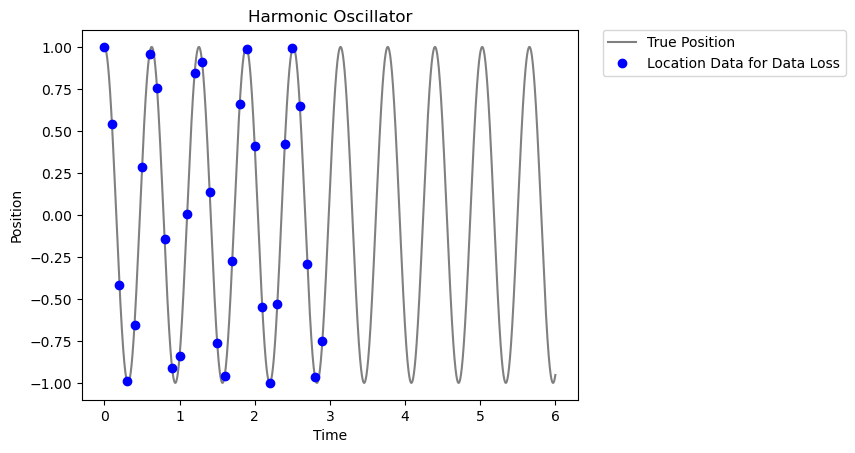

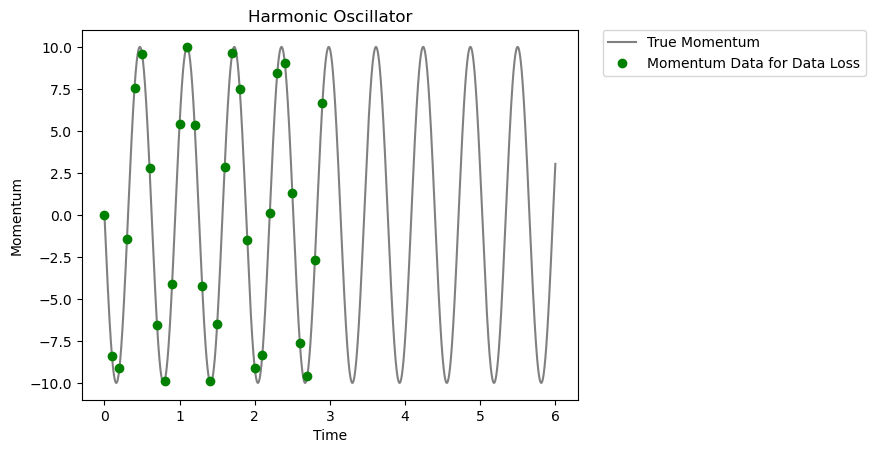

In [ ]:
plt.plot(true_time, true_position, label="True Position", color='grey')
plt.plot(training_dict_uniform_times, training_dict_uniform_positions, "bo", label="Location Data for Data Loss", markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # move legend to outside of figure
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Harmonic Oscillator")
plt.show()

plt.plot(true_time, true_momentum, label="True Momentum", color='grey')
plt.plot(training_dict_uniform_times, training_dict_uniform_momentums, "go", label="Momentum Data for Data Loss", markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # move legend to outside of figure
plt.xlabel("Time")
plt.ylabel("Momentum")
plt.title("Harmonic Oscillator")
plt.show()

In [ ]:
torch.manual_seed(0)

class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.linear_input = nn.Linear(1, hidden_size) # input: time
        self.linear_1 = nn.Linear(hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_output = nn.Linear(hidden_size, 2) # output: (x,p)

    def forward(self, x):
        x = torch.tanh(self.linear_input(x))
        x = torch.tanh(self.linear_1(x))
        x = torch.tanh(self.linear_2(x))
        x = self.linear_output(x)
        return x

hidden_size=16
model = Net(hidden_size=hidden_size)
criterion = nn.MSELoss()
lr=0.01
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.1)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.8)
num_epochs =  3000

training_time_tensor = torch.tensor(training_time, dtype=torch.float32)
training_position_tensor = torch.tensor(training_position, dtype=torch.float32)

batch_size = len(training_time_tensor)
point_zero = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)
point_one=torch.tensor([1.0], dtype=torch.float32).requires_grad_(True)

dataset = TensorDataset(training_time_tensor, training_position_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses_total = []
losses_data = []
losses_IC = []

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    for batch in data_loader:
        batch_time, batch_position = batch

        batch_time = batch_time.requires_grad_(True).view(-1, 1)
        batch_position = batch_position.requires_grad_(True).view(-1, 1)

        # Calculate the data loss
        data_outputs_position = model(training_dict_uniform_times_tensor)[:,0].view(-1,1)
        data_outputs_momentum = model(training_dict_uniform_times_tensor)[:,1].view(-1,1)

        data_loss_position = criterion(data_outputs_position, training_dict_uniform_positions_tensor)
        data_loss_momentum = criterion(data_outputs_momentum, training_dict_uniform_momentums_tensor)

        initial_outputs = model(point_zero)
        p_0_tensor=point_zero
        x_0_tensor=point_one

        initial_condition_loss_position = (initial_outputs[0] - x_0_tensor)**2
        initial_condition_loss_momentum = (initial_outputs[1] - p_0_tensor)**2

        data_loss = 1e10 * data_loss_position + 1e7 * data_loss_momentum
        IC_loss = 1e3 * initial_condition_loss_position + 1e4 * initial_condition_loss_momentum
        total_loss = data_loss + IC_loss

        total_loss.backward()
        optimizer.step()

        losses_data.append(data_loss.item())
        losses_IC.append(IC_loss.item())
        losses_total.append(total_loss.item())


    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Total_Loss: {total_loss.item()}, DataPosition_Loss: {data_loss.item()}, Learning Rate: {optimizer.param_groups[0]["lr"]}')

    # if the learning rate is too low, break out of the loop
    if optimizer.param_groups[0]['lr'] > 1e-4:
        scheduler.step()  # Update the learning rate

avg_total_loss = np.mean(losses_total)
print(f"Epoch {epoch+1}/{num_epochs}, Avg. Total Loss: {avg_total_loss}")


 34%|███▍      | 1016/3000 [00:07<00:13, 151.91it/s]

Epoch [1000/3000], Total_Loss: 53040256.0, DataPosition_Loss: 53014424.0, Learning Rate: 0.01


 67%|██████▋   | 2015/3000 [00:14<00:07, 130.11it/s]

Epoch [2000/3000], Total_Loss: 4688340.0, DataPosition_Loss: 4687896.0, Learning Rate: 0.008


100%|██████████| 3000/3000 [00:22<00:00, 135.59it/s]

Epoch [3000/3000], Total_Loss: 358765.03125, DataPosition_Loss: 358758.09375, Learning Rate: 0.0064
Epoch 3000/3000, Avg. Total Loss: 654578717.3917396


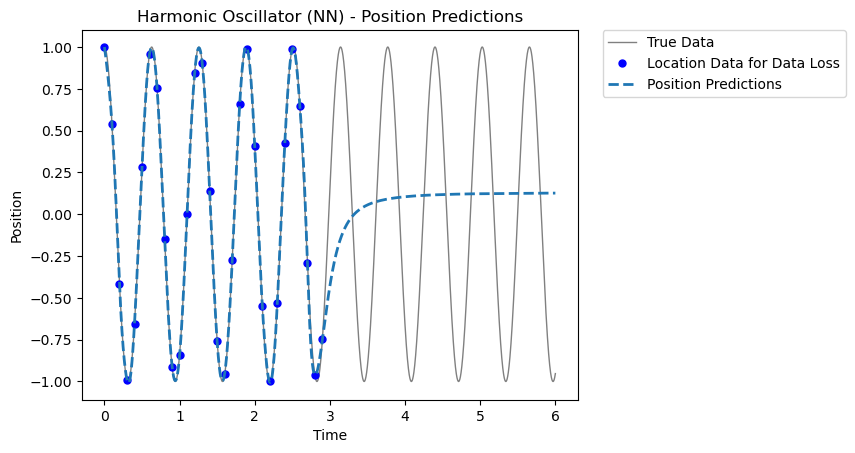

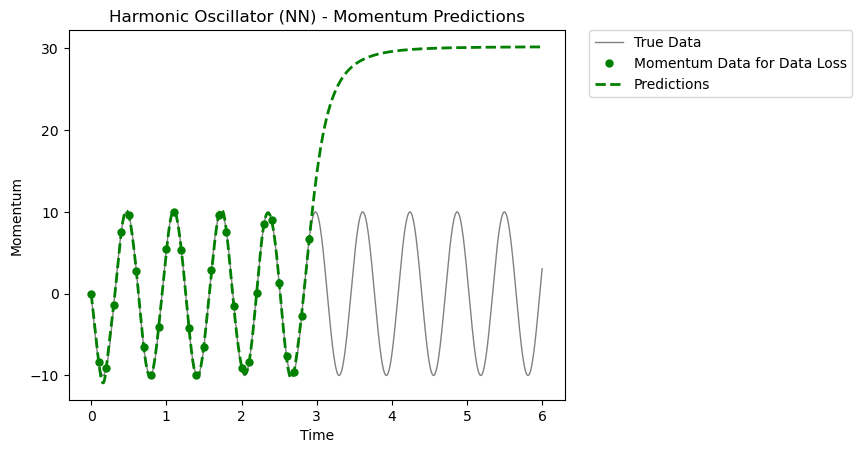

In [ ]:
test_time = torch.tensor(true_time, dtype=torch.float32).view(-1, 1)

# Use the trained model to predict test positions
with torch.no_grad():
    test_predictions = model(test_time).detach()

plt.plot(true_time, true_position, label="True Data", linewidth=1, color='gray' )
plt.plot(training_dict_uniform_times, training_dict_uniform_positions, "bo", label="Location Data for Data Loss", markersize=5)
plt.plot(true_time, test_predictions[:,0], label = f'Position Predictions',linewidth=2, linestyle='dashed')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Harmonic Oscillator (NN) - Position Predictions")
plt.show()

plt.plot(true_time, true_momentum, label="True Data", linewidth=1, color='gray')
plt.plot(training_dict_uniform_times, training_dict_uniform_momentums, "go", label="Momentum Data for Data Loss", markersize=5)
plt.plot(true_time, test_predictions[:,1], label = "Predictions",linewidth=2, color='green', linestyle='dashed')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Time")
plt.ylabel("Momentum")
plt.title("Harmonic Oscillator (NN) - Momentum Predictions")
plt.show()


Final loss: 358765.03125


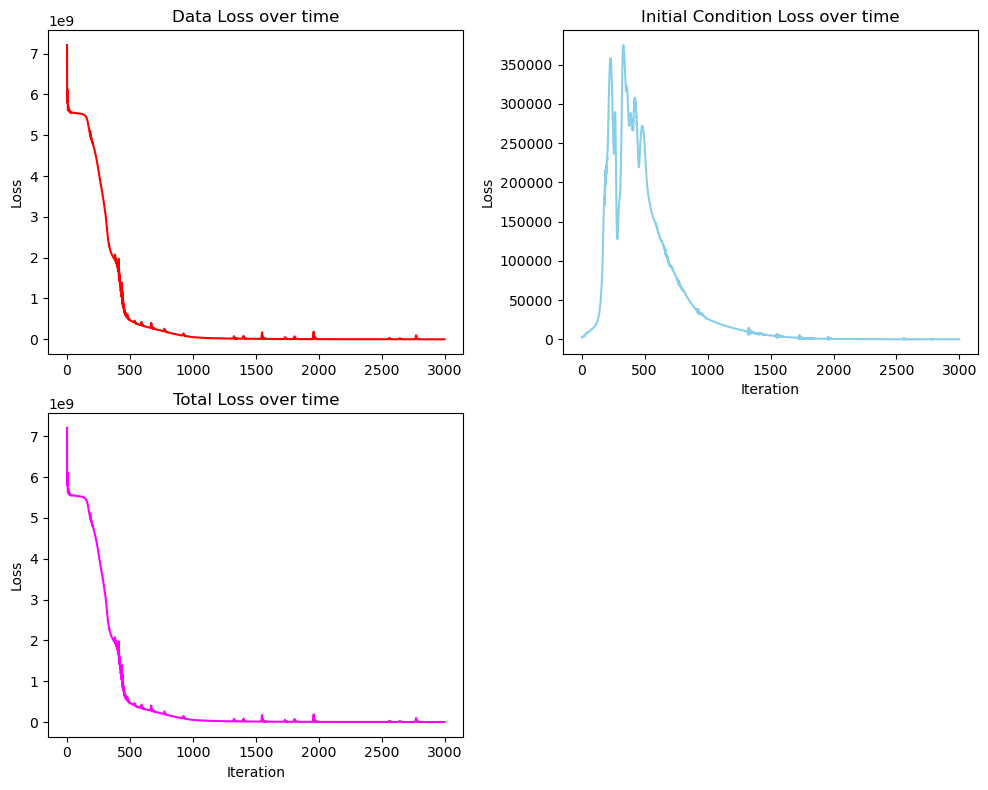

In [ ]:
print('Final loss:', total_loss.item())

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot Data loss position
axs[0, 0].plot(losses_data, label='Data Loss', color='red')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Data Loss over time')
#axs[0, 0].set_ylim(0, 3e8)


# Plot Initial position loss
axs[0, 1].plot(losses_IC, label='Initial Condition Loss', color='skyblue')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Initial Condition Loss over time')
#axs[1].set_ylim(0, 1e5)

# Plot Total loss
axs[1, 0].plot(losses_total, label='Total loss', color='magenta')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_title('Total Loss over time')

axs[1, 1].remove()
plt.tight_layout()
plt.show()